In [62]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math
import numpy as np

In [5]:
# Reads results csv files into df
def read_csv(path):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
    return full_df

In [6]:
# Separates and plots rewards
r_disc = -11 # reward for discarded product
def plot_reward(df, r_nex, title, lr = None):
    # Multiple number of nonexistent issues by r_nex
    reward_nex = r_nex * df['issued_but_nonexistent']
    # Reward for issued but discarded
    reward_disc = r_disc * df['issued_but_discarded']
    # Reward for outdated products
    reward_out = -1 * df['num_outdates']

    # Remaining reward
    reward_rem = df['reward'] - reward_disc - reward_nex - reward_out

    plt.plot(savgol_filter(reward_disc, window_length=200, polyorder=2), label='discarded')
    plt.plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='good')
    plt.plot(savgol_filter(reward_nex, window_length=200, polyorder=2), label='non existing')
    plt.plot(savgol_filter(reward_out, window_length=200, polyorder=2), label='outdates')

    plt.legend(loc="lower right")

    plt.xlabel('Days')
    plt.ylabel('Reward')
    plt.title(title)

    plt.show()

In [76]:
def mov_avg(data):
    data = np.array(data)
    window_width = 1000
    cumsum_vec = np.cumsum(np.insert((data), 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

In [211]:
def plot_multi(dfs):

    r_nex = -50
    r_disc = -11

    cols = 2
    rows = math.ceil(len(dfs) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16,12))
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Reward non-existing
                reward_nex = r_nex * dfs[key]['issued_but_nonexistent']
                # Reward for issued but discarded
                reward_disc = r_disc * dfs[key]['issued_but_discarded']
                # Outdated product reward  = -1
                reward_out = -1*dfs[key]['num_outdates']

                # Remaining reward
                # reward_rem = dfs[key]['reward'] - reward_disc - reward_nex - reward_out

                axes[i][j].plot(mov_avg(reward_disc), label='discarded')
                axes[i][j].plot(mov_avg(reward_nex), label='non-existing')
                axes[i][j].plot(mov_avg(reward_out), label='outdated')
                # axes[i][j].plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='compatible')
                axes[i][j].set(xlabel="Days", ylabel="Reward")
                axes[i][j].legend(loc = 'lower right')
                axes[i][j].set_title(dict_keys[l])
            l += 1
    plt.show()

In [213]:
def plot_multi_satisfied(dfs):
    cols = 2
    rows = math.ceil(len(dfs) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16,12))
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Number satisfied requests
                s = dfs[key]['num_units_requested'] - dfs[key]['issued_but_nonexistent'] - dfs[key]['issued_but_discarded']
                r = dfs[key]['num_units_requested']
                perc = np.array(s/r)

                x = [*range(0, 24550, 982)]

                axes[i][j].plot(mov_avg(perc), label='percentage satisifed')
                [axes[i][j].axvline(_x, linewidth=0.40, color='b') for _x in x]

                axes[i][j].set(xlabel="Days", ylabel="Percentage")
                axes[i][j].legend(loc = 'lower right')
                axes[i][j].set_title(dict_keys[l])
            l += 1

    plt.show()

In [84]:
def plot_satisfied(df, title):
    s = df['num_units_requested'] - df['issued_but_nonexistent'] - df['issued_but_discarded']
    r = df['num_units_requested']
    perc = np.array(s/r)

    window_width = 2000
    cumsum_vec = np.cumsum(np.insert((perc), 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

    plt.plot(ma_vec, label='satisfied')

    plt.legend(loc="lower right")

    plt.ylabel('Number units')
    plt.xlabel('Days')

    plt.title(title)

    plt.show()
    return

In [193]:
def plot_loss_multi(dfs, title):
    dict_keys = [k for k in dfs.keys()]

    for k in dict_keys:
        plt.plot(mov_avg(dfs[k]['day_loss']), label=k)

    plt.legend(loc = 'lower right')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Days')

    plt.show()

### Network architecture
#### Input size

```
input_size = len(np.ravel(self.env.state))
```
output = number of actions (8)
state dimension = 8 x 8
8:   number of blood groups
9:   max age (5) + max lead time (3) + current request (1)

input
size = 8 * 9 = 72

#### Model
```
input -> [64, relu] -> [64, relu] -> [output, linear]
```

### 1 Epsilon tests

Alpha = 0.001
Episode = 2.5 years
25 episodes

In [112]:
e02 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.2/target_False/target_250')
e04 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_False/target_250')
e06 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.6/target_False/target_250')
e08 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.8/target_False/target_250')

epsilons = {'ε = 0.2':e02, 'ε = 0.4':e04, 'ε = 0.6':e06, 'ε = 0.8':e08}

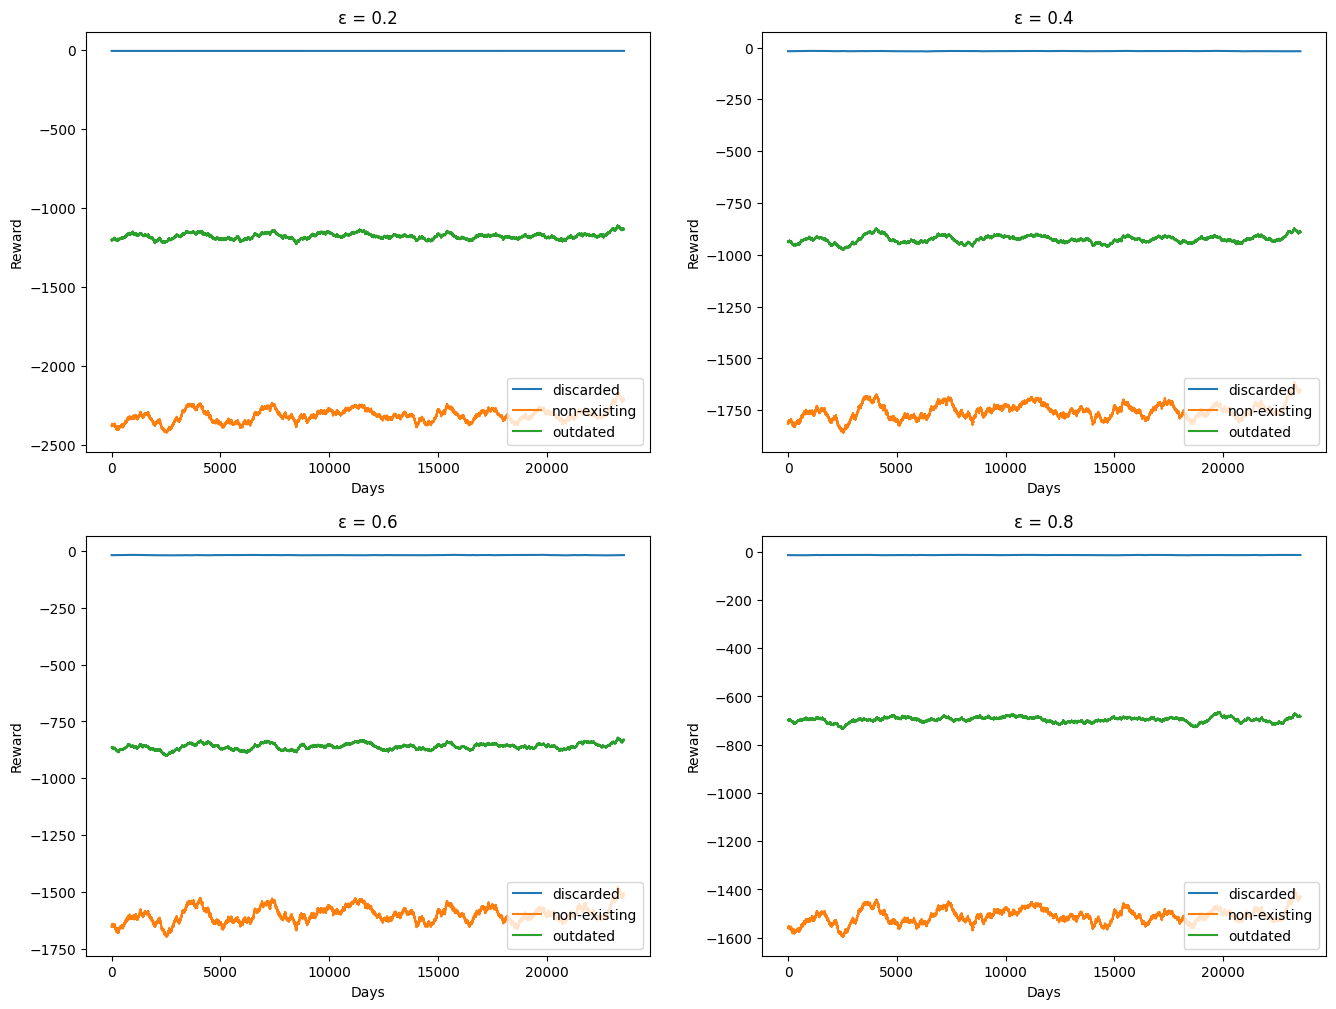

In [212]:
plot_multi(epsilons)

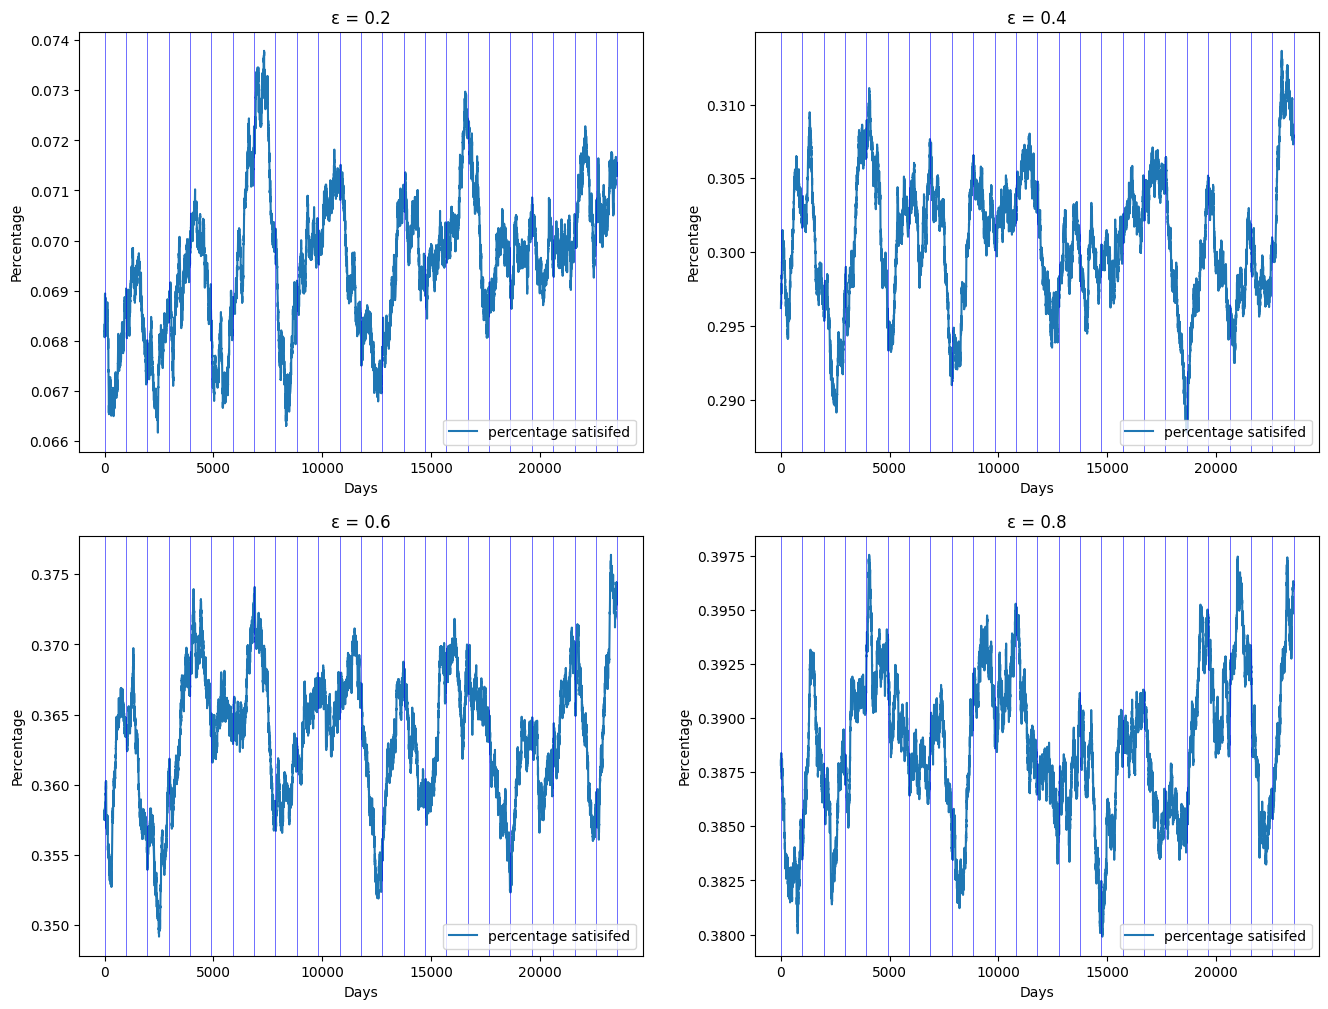

In [214]:
plot_multi_satisfied(epsilons)

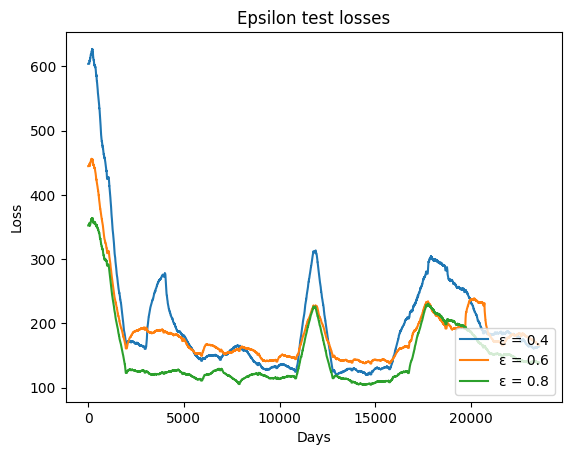

In [215]:
epsilons_468 = {'ε = 0.4':e04, 'ε = 0.6':e06, 'ε = 0.8':e08}
plot_loss_multi(epsilons_468, 'Epsilon test losses')

### 2 Target network frequency tests

Epsilon = 0.4
Alpha = 0.001
Episode = 2.5 years
25 episodes

In [217]:
t100 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_100')
t250 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_250')
t500 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_500')
t750 = read_csv('results/request_scratch/a0.001_g0.99_b50/64_64/e0.4/target_True/target_750')

targets = {'N = 100':t100, 'N = 250':t250, 'N = 500':t500, 'N = 750':t750}

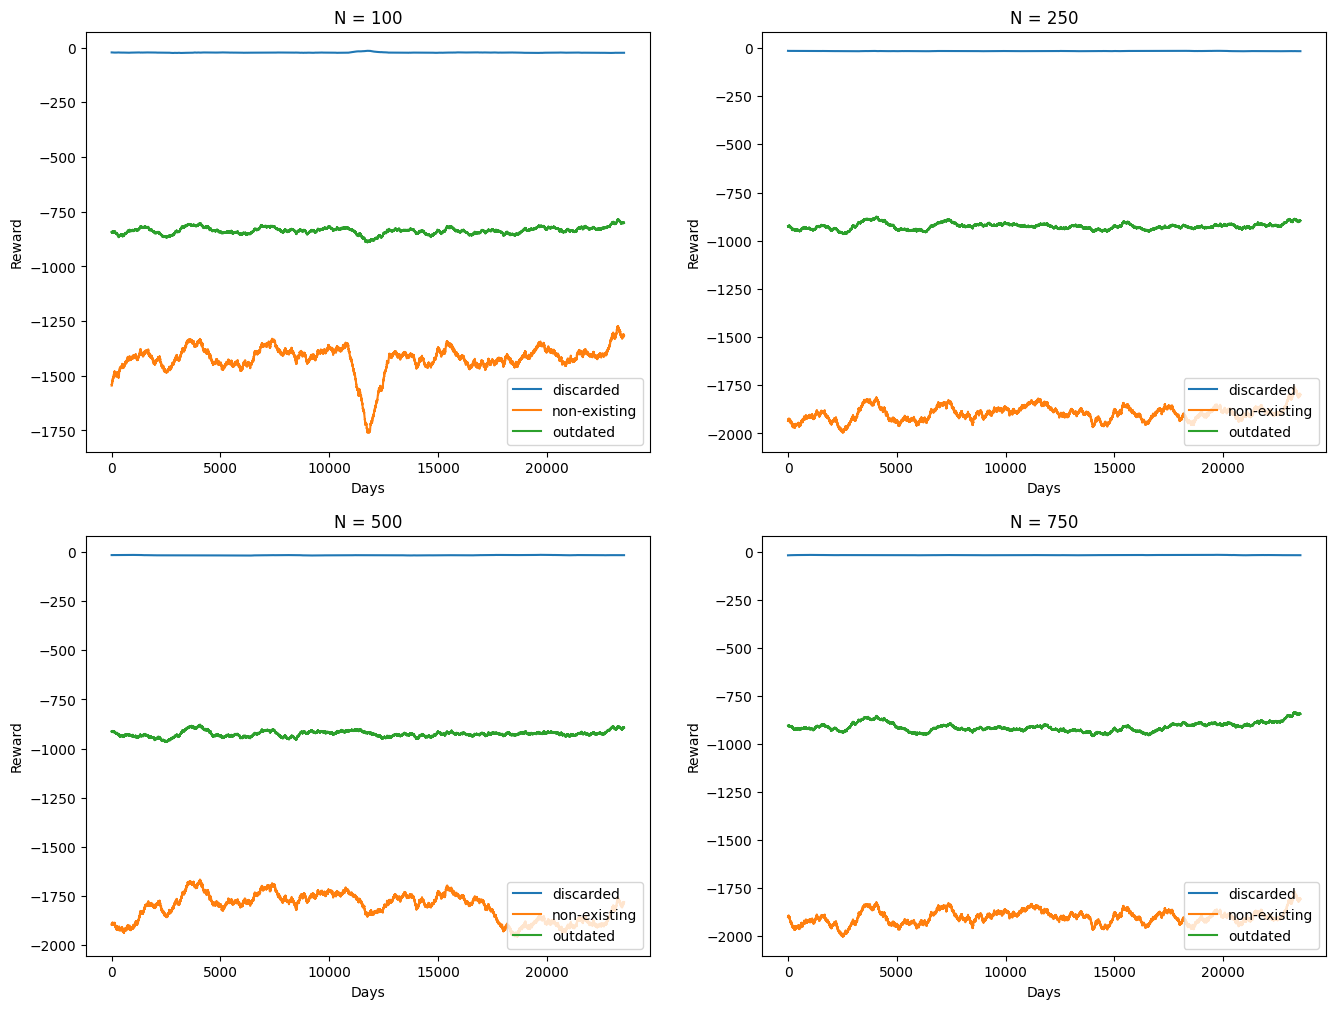

In [218]:
plot_multi(targets)

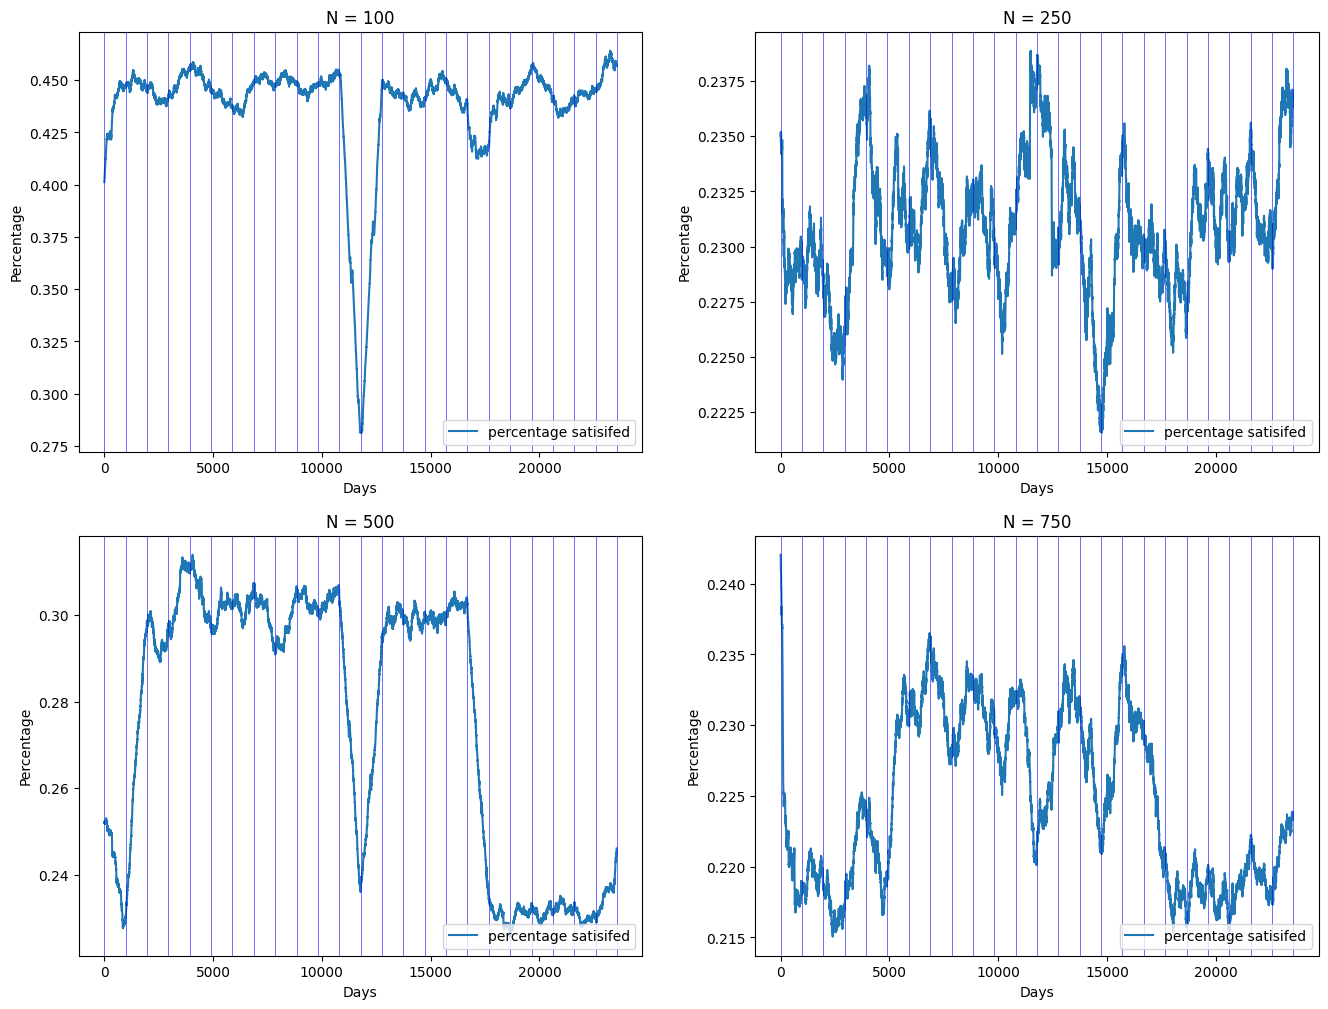

In [219]:
plot_multi_satisfied(targets)

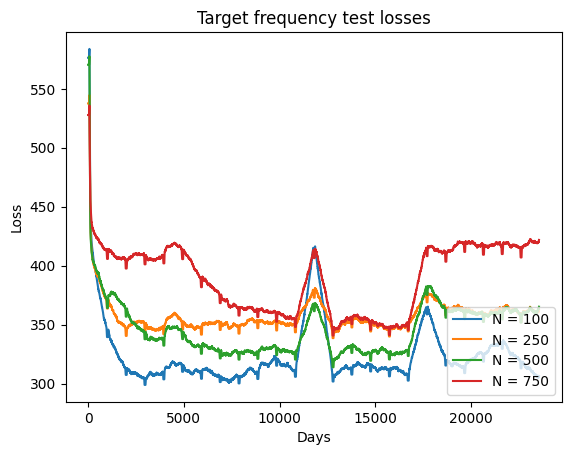

In [220]:
plot_loss_multi(targets, 'Target frequency test losses')

In [168]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

In [186]:
columns = ['num_units_requested', 'num_supplied_products', 'reward', 'day_loss', 'issued_but_nonexistent', 'issued_but_discarded', 'num_outdates', 'num_shortages']
episode13 = e08[11784:12766]
episode12 = e08[10802:11784]

In [189]:
describe(episode12[columns], ['sum'])

C:\Users\evani\AppData\Local\Temp\ipykernel_18036\4251588923.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return d.append(df.reindex(d.columns, axis = 1).agg(stats))


,num_units_requested,num_supplied_products,reward,day_loss,issued_but_nonexistent,issued_but_discarded,num_outdates,num_shortages
count,982.000000,982.000000,9.820000e+02,982.000000,982.000000,982.000000,982.000000,982.000000
mean,49.661914,32.091650,-2.177721e+03,116.283554,29.560081,1.213849,686.364562,30.773931
std,22.101881,25.407138,1.113357e+03,56.498806,15.732018,1.302038,693.301060,15.822467
min,4.000000,0.000000,-6.708000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,6.000000,-2.857500e+03,88.340160,18.000000,0.000000,48.250000,19.000000
50%,48.000000,33.000000,-1.996500e+03,113.066765,28.000000,1.000000,487.000000,29.000000
75%,65.000000,55.000000,-1.344250e+03,142.092815,39.000000,2.000000,1140.750000,40.750000
max,129.000000,150.000000,-1.500000e+02,599.964539,90.000000,7.000000,3502.000000,93.000000
sum,48768.000000,31514.000000,-2.138522e+06,114190.449890,29028.000000,1192.000000,674010.000000,30220.000000


In [190]:
describe(episode13[columns], ['sum'])

C:\Users\evani\AppData\Local\Temp\ipykernel_18036\4251588923.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return d.append(df.reindex(d.columns, axis = 1).agg(stats))


,num_units_requested,num_supplied_products,reward,day_loss,issued_but_nonexistent,issued_but_discarded,num_outdates,num_shortages
count,982.000000,982.000000,9.820000e+02,982.000000,982.000000,982.000000,982.000000,982.000000
mean,49.330957,31.765784,-2.190012e+03,228.295807,29.588595,1.267821,696.636456,30.856415
std,21.178611,24.408228,1.067513e+03,121.553745,15.275913,1.370493,664.030523,15.389299
min,4.000000,0.000000,-5.570000e+03,0.000000,1.000000,0.000000,0.000000,1.000000
25%,33.000000,8.000000,-2.820750e+03,161.502647,18.000000,0.000000,74.250000,19.000000
50%,48.000000,32.000000,-2.057000e+03,216.974373,28.500000,1.000000,577.500000,30.000000
75%,63.000000,54.000000,-1.376500e+03,282.643776,39.000000,2.000000,1149.500000,40.000000
max,121.000000,150.000000,-1.110000e+02,878.846069,87.000000,8.000000,2913.000000,89.000000
sum,48443.000000,31194.000000,-2.150592e+06,224186.482796,29056.000000,1245.000000,684097.000000,30301.000000
